# Demystifying: Machine Learning

https://www.optica.org/events/congress/advanced_photonics_congress/program/demystifying/

Carlos Natalino $^1$ and Ben Mills $^2$

$^1$ Department of Electrical Engineering, Chalmers University of Technology, Gothenburg, Sweden. https://www.chalmers.se/en/persons/carda/

$^2$ University of Southampton, Southampton, UK. https://www.southampton.ac.uk/people/5x7lvp/doctor-ben-mills

## Part 1.3.1: Applying semi-supervised for anomaly detection

General links can be found here: https://github.com/carlosnatalino/demystifying-ml/

### Step 1: setup environment, import relevant libraries and files

In [22]:
# Here we concentrate all the imports
import glob
import random
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import requests
import numpy as np
from sklearn import preprocessing
from sklearn import svm
from sklearn import decomposition
import sklearn.metrics as skmetrics

%matplotlib inline

In [23]:
sys.version

'3.12.4 (main, Jun  6 2024, 18:26:44) [Clang 15.0.0 (clang-1500.3.9.4)]'

In [24]:
import matplotlib
matplotlib.__version__

'3.9.1'

In [25]:
pd.__version__

'2.2.2'

In [26]:
requests.__version__

'2.32.3'

In [27]:
import sklearn
sklearn.__version__

'1.5.1'

In [28]:
# check the `datasets` folder on GitHub for a complete list of the service datasets available.
service_id = 1002

In [29]:
# Here we list the files that are within the folder.
os.makedirs("./figures", exist_ok=True)
os.makedirs("./downloads", exist_ok=True)
if not os.path.exists(f"./downloads/service_{service_id}_data.csv"):
    with open(f"./downloads/service_{service_id}_data.csv", "wt", encoding="utf-8") as file:
        content = requests.get(f"https://github.com/carlosnatalino/demystifying-ml/raw/main/datasets/service_{service_id}_data.csv")
        file.write(content.text)
os.listdir("./downloads")

['service_1002_data.csv', 'nobel-eu_200_initial_dataset.csv']

In [30]:
# Setting seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

### Step 2: load the data

In [31]:
# Listing data files.
glob.glob("./downloads/service_*_data.csv")

['./downloads/service_1002_data.csv']

In [32]:
# Pick one of the service IDs shown above.
data_ad = pd.read_csv(f"./downloads/service_{service_id}_data.csv")
data_ad.describe()

,GSNR,ASE,NLI,status
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,12.424359,12.495753,30.433592,0.500000
std,0.649325,0.665375,0.519377,0.500013
min,11.205421,11.244507,29.683639,0.000000
25%,11.815239,11.871565,30.014746,0.000000
50%,12.539121,12.614530,30.354382,0.500000
75%,13.031819,13.116411,30.683544,1.000000
max,13.404702,13.508048,31.683605,1.000000


### Step 3: Visualize the data using principal component analysis

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [33]:
pca = decomposition.PCA(n_components=2)
data_ad_transf = pca.fit_transform(data_ad)
data_ad_transf.shape

(20000, 2)

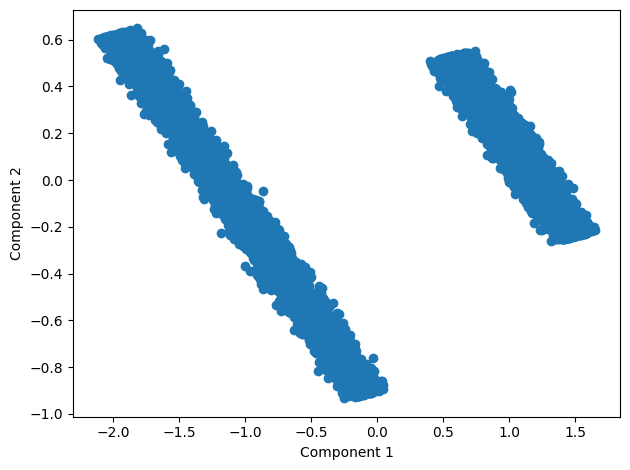

In [34]:
plt.figure()
plt.scatter(data_ad_transf[:, 0], data_ad_transf[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

### Step 4: Split dataset between normal and abnormal

In [35]:
data_normal = data_ad[(data_ad["status"]==0)].drop(["status"], axis=1)
data_normal.describe()

,GSNR,ASE,NLI
count,10000.000000,10000.000000,10000.000000
mean,13.033691,13.118565,30.187688
std,0.145059,0.153290,0.289568
min,12.666838,12.735954,29.683646
25%,12.915745,12.993071,29.938181
50%,13.031836,13.116421,30.185083
75%,13.151189,13.242934,30.441816
max,13.404702,13.508048,30.683605


In [36]:
# for semi-supervised and unsupervised learning, the scaling only considers the normal data since we should assume we don't have data about anomalies at the time of defining the model
scaler = preprocessing.StandardScaler().fit(data_normal)
data_normal_scaled = scaler.transform(data_normal)

In [37]:
data_abnormal = data_ad[(data_ad["status"]==1)].drop(["status"], axis=1)
data_abnormal.describe()
data_abnormal_scaled = scaler.transform(data_abnormal)

### Step 5: Training a semi-supervised algorithm

In this example, we use one-class support vector machine (OC-SVM), with documentation available [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html).

#### Prepare for training

Here we divide the normal dataset into two subsets, one for training, and one for testing.
You can control the portion used for training and testing with the `train_size` parameter.

In [38]:
print(data_normal_scaled.shape)
X_train = data_normal_scaled[:data_normal_scaled.shape[0]//2, :]
X_test = data_normal_scaled[data_normal_scaled.shape[0]//2:, :]
print(X_train.shape)
print(X_test.shape)

(10000, 3)
(5000, 3)
(5000, 3)


#### Performing hyperparameter analysis

If you are curious about a more detailed example, you can find it here: https://github.com/carlosnatalino/JLT-2020-ML-Practical-Perspective/blob/master/training-ul-ssl-models.ipynb

In [39]:
# hyperparameters
nus = [0.01, 0.1, .3, .5, .7, .9]
kernels = ['rbf', 'linear', 'sigmoid', 'poly']
gammas = [0.001, 0.1, 0.2, 0.5, 0.7, .9]
best_configuration = None
highest_f1 = .0
best_model = None

In [40]:
print("nu\tkernel\tgamma\tf1 score")
for nu in nus:
    for kernel in kernels:
        for gamma in gammas:
            ocsvm = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            ocsvm.fit(X_train)  # note that here we only use data from the normal dataset
            y_pred_normal = ocsvm.predict(X_test)
            y_pred_abnormal = ocsvm.predict(data_abnormal_scaled)

            f1 = skmetrics.f1_score(
                np.concatenate((np.full(y_pred_normal.shape, fill_value=1), np.full(y_pred_abnormal.shape, fill_value=-1))),
                np.concatenate((y_pred_normal, y_pred_abnormal)), 
            )

            message = f"{nu}\t{kernel}\t{gamma}\t{f1:.3f}"
            if f1 > highest_f1:
                highest_f1 = f1
                best_configuration = nu, kernel, gamma
                best_model = ocsvm
                message += "\t* best!"
            print(message)
print("\nDone!")
print("Best configuration:", best_configuration)
print("f1 score:", highest_f1)

nu	kernel	gamma	f1 score
0.01	rbf	0.001	0.994	* best!
0.01	rbf	0.1	0.994	* best!
0.01	rbf	0.2	0.994
0.01	rbf	0.5	0.994	* best!
0.01	rbf	0.7	0.994
0.01	rbf	0.9	0.994
0.01	linear	0.001	0.210
0.01	linear	0.1	0.210
0.01	linear	0.2	0.210
0.01	linear	0.5	0.210
0.01	linear	0.7	0.210
0.01	linear	0.9	0.210
0.01	sigmoid	0.001	0.740
0.01	sigmoid	0.1	0.994
0.01	sigmoid	0.2	0.995	* best!
0.01	sigmoid	0.5	0.496
0.01	sigmoid	0.7	0.495
0.01	sigmoid	0.9	0.495
0.01	poly	0.001	0.761
0.01	poly	0.1	0.356
0.01	poly	0.2	0.079
0.01	poly	0.5	0.183
0.01	poly	0.7	0.229
0.01	poly	0.9	0.263
0.1	rbf	0.001	0.947
0.1	rbf	0.1	0.949
0.1	rbf	0.2	0.948
0.1	rbf	0.5	0.946
0.1	rbf	0.7	0.946
0.1	rbf	0.9	0.945
0.1	linear	0.001	0.536
0.1	linear	0.1	0.536
0.1	linear	0.2	0.536
0.1	linear	0.5	0.536
0.1	linear	0.7	0.536
0.1	linear	0.9	0.536
0.1	sigmoid	0.001	0.267
0.1	sigmoid	0.1	0.466
0.1	sigmoid	0.2	0.461
0.1	sigmoid	0.5	0.946
0.1	sigmoid	0.7	0.944
0.1	sigmoid	0.9	0.925
0.1	poly	0.001	0.275
0.1	poly	0.1	0.059
0.1	poly	0.2	0.186


### Step 6: Visualizing the results

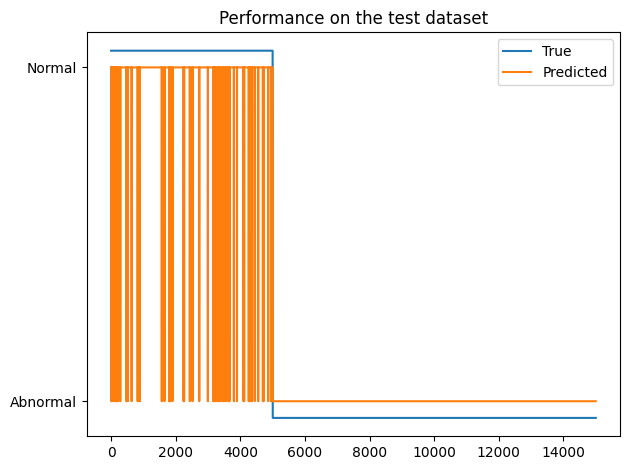

In [41]:
y_pred_normal = best_model.predict(X_test)
y_pred_abnormal = best_model.predict(data_abnormal_scaled)

plt.figure()

plt.plot(np.concatenate((np.full((y_pred_normal.shape), fill_value=1.1), np.full(y_pred_abnormal.shape, fill_value=-1.1))), label="True")
plt.plot(np.concatenate((y_pred_normal, y_pred_abnormal)), label="Predicted")
plt.legend(loc=0)
plt.title("Performance on the test dataset")
plt.yticks([-1, 1], ["Abnormal", "Normal"])
plt.tight_layout()
plt.show()